In [2]:
!pip install -q kaggle

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mousumi5570","key":"61126588bcc73270155d751f6c281a98"}'}

In [4]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle competitions download -c nlp-getting-started

test.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)


#Real or Not? NLP with Disaster Tweets
## Predict which Tweets are about real disasters and which ones are not
https://www.kaggle.com/c/nlp-getting-started

First part of the notebook is edited from https://www.kaggle.com/shahules/basic-eda-cleaning-and-glove

In [9]:
import nltk

In [10]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import  Counter
plt.style.use('ggplot')
stop=set(stopwords.words('english'))
import re
from nltk.tokenize import word_tokenize
import gensim
import string
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam

Using TensorFlow backend.


In [12]:
import os

In [13]:
tweet= pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
tweet.head(3)
#test.head(3)
#print(tweet['text'][0])

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1


In [14]:
print('There are {} rows and {} columns in train'.format(tweet.shape[0],tweet.shape[1]))
print('There are {} rows and {} columns in test'.format(test.shape[0],test.shape[1]))

There are 7613 rows and 5 columns in train
There are 3263 rows and 4 columns in test


# Class distribution
Before we begin with anything else,let's check the class distribution.There are only two classes 0 and 1.

Text(0, 0.5, 'samples')

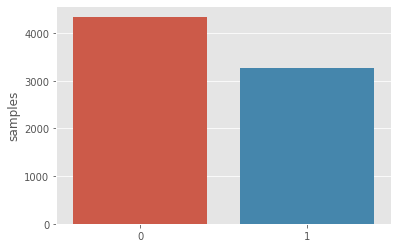

In [15]:
x=tweet.target.value_counts()
#print(x)
#print(x.index)
sns.barplot(x.index,x)
plt.gca().set_ylabel('samples')

#Exploratory Data Analysis of tweets
First,we will do very basic analysis,that is character level,word level and sentence level analysis.

#Number of characters in tweets

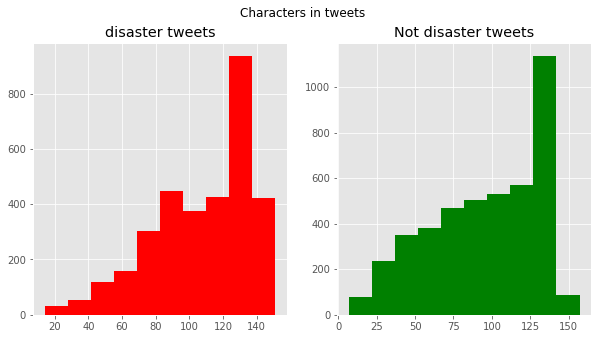

In [16]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=tweet[tweet['target']==1]['text'].str.len()
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster tweets')
tweet_len=tweet[tweet['target']==0]['text'].str.len()
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Characters in tweets')
plt.show()

The distribution of both seems to be almost same.120 t0 140 characters in a tweet are the most common among both.

# Number of words in a tweet

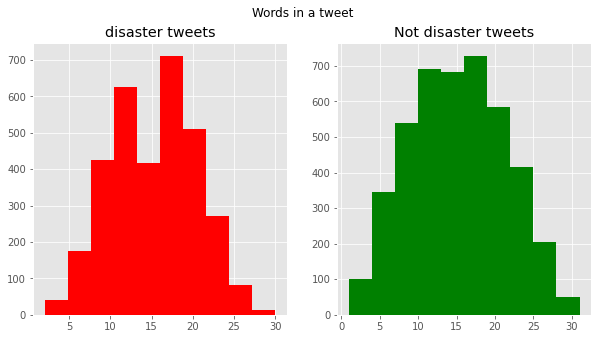

In [18]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=tweet[tweet['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster tweets')
tweet_len=tweet[tweet['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Words in a tweet')
plt.show()

# Word Distribution in all Tweet

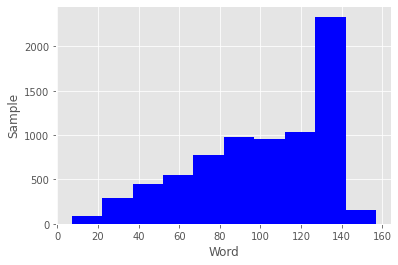

In [20]:
tweet_len=tweet['text'].str.len()
plt.hist(tweet_len, color='blue')
plt.xlabel('Word')
plt.ylabel('Sample')
plt.show()

# Average word length in a tweet

In [21]:
word = tweet['text'][0:5].str.split().apply(lambda x : [len(i) for i in x])
print('character count of each word in text')
print(word)
print('Average word length in text')
print(word.map(lambda x: np.mean(x)))

character count of each word in text
0             [3, 5, 3, 3, 6, 2, 4, 11, 3, 5, 7, 2, 3]
1                                [6, 4, 4, 2, 5, 5, 6]
2    [3, 9, 5, 2, 8, 2, 6, 3, 5, 8, 2, 9, 2, 5, 10,...
3                          [6, 6, 7, 10, 10, 6, 2, 10]
4    [4, 3, 4, 4, 5, 4, 4, 7, 2, 5, 4, 10, 5, 4, 1, 6]
Name: text, dtype: object
Average word length in text
0    4.384615
1    4.571429
2    5.090909
3    7.125000
4    4.500000
Name: text, dtype: float64


0             [3, 5, 3, 3, 6, 2, 4, 11, 3, 5, 7, 2, 3]
1                                [6, 4, 4, 2, 5, 5, 6]
2    [3, 9, 5, 2, 8, 2, 6, 3, 5, 8, 2, 9, 2, 5, 10,...
3                          [6, 6, 7, 10, 10, 6, 2, 10]
4    [4, 3, 4, 4, 5, 4, 4, 7, 2, 5, 4, 10, 5, 4, 1, 6]
5    [10, 6, 2, 10, 4, 2, 6, 2, 4, 10, 3, 2, 4, 6, ...
6           [6, 9, 5, 4, 6, 5, 8, 2, 7, 2, 8, 8, 7, 5]
7        [3, 2, 3, 2, 3, 4, 3, 1, 3, 3, 1, 4, 2, 3, 8]
8                [7, 2, 9, 10, 9, 3, 2, 3, 8, 6, 3, 6]
9                       [3, 6, 4, 3, 7, 2, 6, 2, 3, 7]
Name: text, dtype: object


Text(0.5, 0.98, 'Average word length in each tweet')

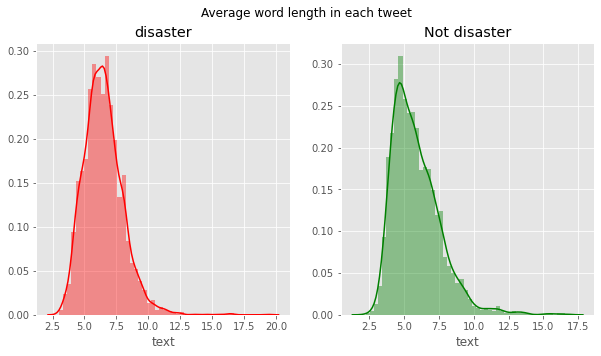

In [22]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word=tweet[tweet['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
print(word[0:10])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('disaster')
word=tweet[tweet['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Not disaster')
fig.suptitle('Average word length in each tweet')

In [23]:
def create_corpus(target):
    corpus=[]
    
    for x in tweet[tweet['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

# Common stopwords in tweets¶
First we will analyze tweets with class 0.

In [24]:
corpus=create_corpus(0)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:15]
print("Word, ","Count")
print(top)

Word,  Count
[('the', 1524), ('a', 1115), ('to', 1099), ('and', 840), ('of', 834), ('in', 720), ('you', 529), ('is', 512), ('for', 452), ('my', 442), ('on', 387), ('with', 349), ('that', 326), ('it', 290), ('be', 268)]


<BarContainer object of 15 artists>

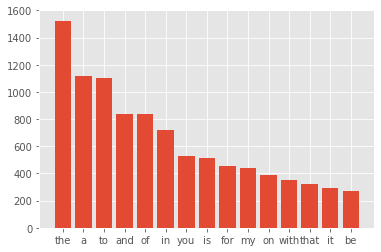

In [25]:
x,y=zip(*top)
plt.bar(x,y)

Now,we will analyze tweets with class 1.

<BarContainer object of 15 artists>

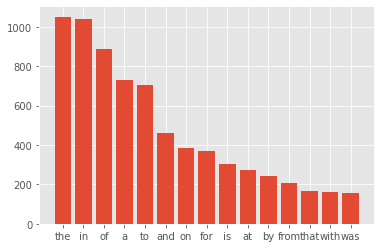

In [26]:
corpus=create_corpus(1)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:15] 
    


x,y=zip(*top)
plt.bar(x,y)

In both of them,"the" dominates which is followed by "a" in class 0 and "in" in class 1.

# Analyzing punctuations.
First let's check tweets indicating real disaster.

Punctuation:  !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


<BarContainer object of 18 artists>

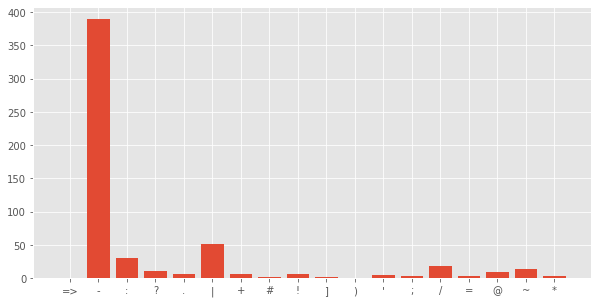

In [27]:
plt.figure(figsize=(10,5))
corpus=create_corpus(1)

dic=defaultdict(int)
import string
special = string.punctuation
print('Punctuation: ', special)
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y)

Now we will move to non-real disaster tweet

<BarContainer object of 20 artists>

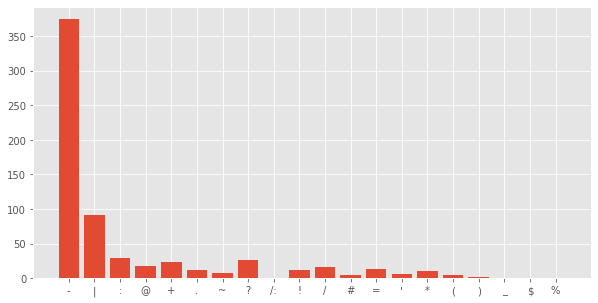

In [28]:
plt.figure(figsize=(10,5))
corpus=create_corpus(0)

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y)

## Common words ?

In [29]:
counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:40]:
    if (word not in stop) :
        x.append(word)
        y.append(count)

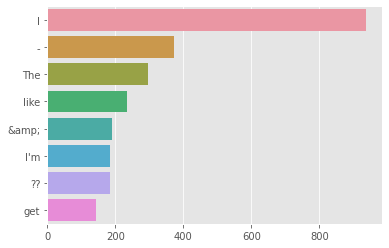

In [30]:
sns.barplot(x=y,y=x)

Lot of cleaning needed !

Lot of cleaning needed !

#Ngram analysis
we will do a bigram (n=2) analysis over the tweets.Let's check the most common bigrams in tweets.

In [31]:
def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

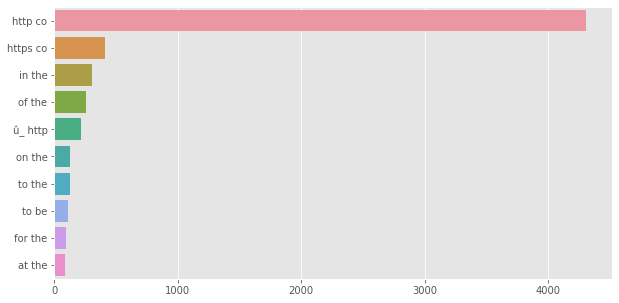

In [32]:
plt.figure(figsize=(10,5))
top_tweet_bigrams=get_top_tweet_bigrams(tweet['text'])[:10]
x,y=map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x)

We will need lot of cleaning here..

Data Cleaning
As we know,twitter tweets always have to be cleaned before we go onto modelling.So we will do some basic cleaning such as spelling correction,removing punctuations,removing html tags and emojis etc.So let's start.

In [33]:
dfTrain=pd.concat([tweet])
dfTrain.shape
print(dfTrain['text'][0])
print(dfTrain['target'][0])

Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
1


In [34]:
dfTest=pd.concat([test])
dfTest.shape

(3263, 4)




# Removing urls




In [35]:
example="New competition launched :https://www.kaggle.com/c/nlp-getting-started"

In [36]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

remove_URL(example)

'New competition launched :'

In [37]:
dfTrain['text']=dfTrain['text'].apply(lambda x : remove_URL(x))

In [38]:
dfTest['text']=dfTest['text'].apply(lambda x : remove_URL(x))

# Removing HTML tags

In [39]:
example = """<div>
<h1>Real or Fake</h1>
<p>Kaggle </p>
<a href="https://www.kaggle.com/c/nlp-getting-started">getting started</a>
</div>"""

In [40]:
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)
print(remove_html(example))


Real or Fake
Kaggle 
getting started



In [41]:
dfTrain['text']=dfTrain['text'].apply(lambda x : remove_html(x))

In [42]:
dfTest['text']=dfTest['text'].apply(lambda x : remove_html(x))

# Romoving Emojis

In [43]:
# Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

remove_emoji("Omg another Earthquake 😔😔")

'Omg another Earthquake '

In [44]:
dfTrain['text']=dfTrain['text'].apply(lambda x: remove_emoji(x))

In [45]:
dfTest['text']=dfTest['text'].apply(lambda x: remove_emoji(x))

# Removing punctuations

In [46]:
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

example="I am a #king"
print(remove_punct(example))

I am a king


In [47]:
dfTrain['text']=dfTrain['text'].apply(lambda x : remove_punct(x))

In [48]:
dfTest['text']=dfTest['text'].apply(lambda x : remove_punct(x))

# Spelling Correction
Even if I'm not good at spelling I can correct it with python :) I will use pyspellcheker to do that.

In [49]:
!pip install pyspellchecker

     |████████████████████████████████| 1.9MB 3.1MB/s 


In [50]:
from spellchecker import SpellChecker

spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)
        
text = "corect me plese"
correct_spellings(text)

'correct me please'

In [52]:
dfTrain['text']=dfTrain['text'].apply(lambda x : correct_spellings(x))

KeyboardInterrupt: ignored

In [ ]:
dfTest['text']=dfTest['text'].apply(lambda x : correct_spellings(x))

# Single Layer GRU

In [56]:
import numpy as np

import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [77]:
vocab_size = 5000
embedding_dim = 64
max_length = 32
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

#Train = 5000, validation = 7613-5000
training_size = 5000

In [78]:
training_sentences = dfTrain['text'][0:training_size]
testing_sentences = dfTrain['text'][training_size:]
training_labels = dfTrain['target'][0:training_size]
testing_labels = dfTrain['target'][training_size:]

In [79]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

In [72]:
word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [73]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 64, 128)           1280000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                31104     
_________________________________________________________________
dense_8 (Dense)              (None, 6)                 390       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 7         
Total params: 1,311,501
Trainable params: 1,311,501
Non-trainable params: 0
_________________________________________________________________


In [80]:
num_epochs = 50

training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [81]:
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=1)

Epoch 1/50
157/157 [==============================] - 11s 72ms/step - loss: 0.0248 - accuracy: 0.9856 - val_loss: 2.3824 - val_accuracy: 0.6774
Epoch 2/50
157/157 [==============================] - 12s 74ms/step - loss: 0.0247 - accuracy: 0.9860 - val_loss: 2.4763 - val_accuracy: 0.6812
Epoch 3/50
157/157 [==============================] - 12s 74ms/step - loss: 0.0247 - accuracy: 0.9852 - val_loss: 2.5234 - val_accuracy: 0.6774
Epoch 4/50
157/157 [==============================] - 11s 73ms/step - loss: 0.0248 - accuracy: 0.9850 - val_loss: 2.5448 - val_accuracy: 0.6781
Epoch 5/50
157/157 [==============================] - 11s 73ms/step - loss: 0.0246 - accuracy: 0.9868 - val_loss: 2.5363 - val_accuracy: 0.6747
Epoch 6/50
157/157 [==============================] - 11s 71ms/step - loss: 0.0247 - accuracy: 0.9854 - val_loss: 2.5899 - val_accuracy: 0.6812
Epoch 7/50
157/157 [==============================] - 11s 73ms/step - loss: 0.0243 - accuracy: 0.9856 - val_loss: 2.5452 - val_accuracy:

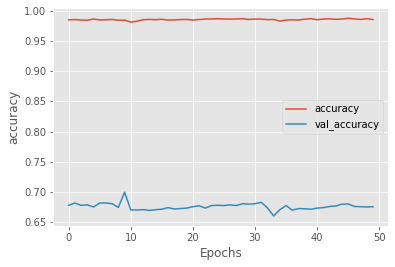

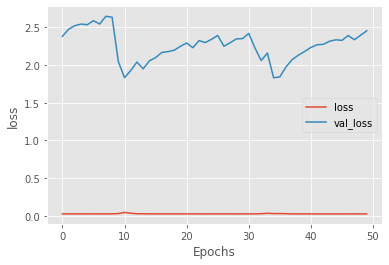

In [82]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

# Making submission

In [83]:
sample_sub=pd.read_csv('sample_submission.csv')

In [87]:
real_test_sequences = tokenizer.texts_to_sequences(dfTest['text'])
real_test_padded = pad_sequences(real_test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [88]:
real_test_padded = np.array(real_test_padded)

In [91]:
y_pre=model.predict(real_test_padded)
y_pre=np.round(y_pre).astype(int).reshape(3263)
sub=pd.DataFrame({'id':sample_sub['id'].values.tolist(),'target':y_pre})
sub.to_csv('submission.csv',index=False)

In [93]:
sub.head()

,id,target
0,0,0
1,2,1
2,3,1
3,9,1
4,11,1


# Let's Do some more fun!!!

##Word Cloud##

In [95]:
!pip install wordcloud

In [97]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt 
import pandas as pd 

In [99]:
comment_words = '' 
stopwords = stop

###Non-Real Tweets###

In [105]:
for val in dfTrain[dfTrain['target'] == 0]['text']:  
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "

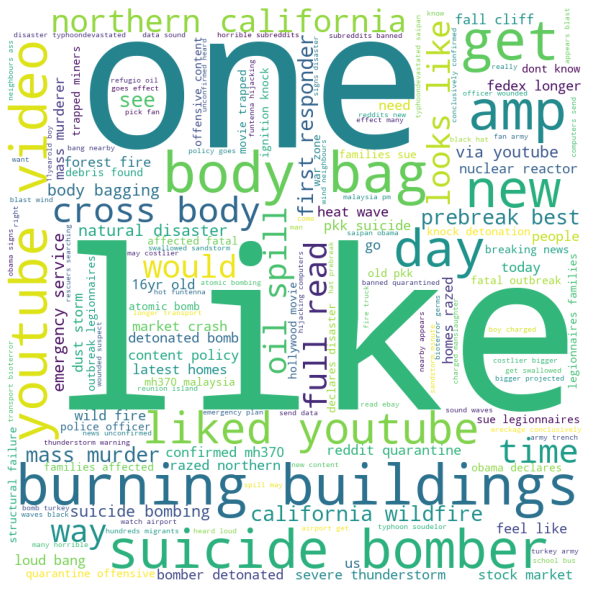

In [106]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

###Real Tweets###

In [109]:
print(dfTrain[dfTrain['target'] == 1].shape[0])
print(dfTrain[dfTrain['target'] == 0].shape[0])

3271
4342


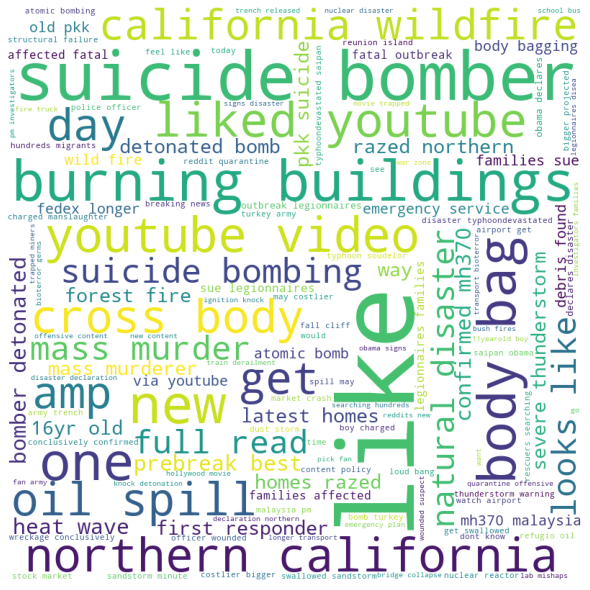

In [107]:
for val in dfTrain[dfTrain['target'] == 1]['text']:  
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()